# Classification of the Oxford Flowers 102 dataset using PyTorch

Ok, one more CNN trained to classify an image dataset. Let's find out what happens with less "tidy" data. This time I'm using the Oxford Flowers 102 dataset [[1]](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/), which contains 102 categories of flowers. This dataset has an unusual data split: the training and validation datasets each have relatively few images (1,020 i.e. 10 images per class), while the test dataset has 6,149 images. Below I switch them to use the largest dataset for training, and one of the smaller datasets for testing. The images feature pictures of single flowers; the data can be simplified by applying pre-processing steps that segment the images and isolate the flowers from their background [[2]](https://doi.org/10.1109/ICVGIP.2008.47).

I start by checking what a CNN can achieve on the "raw" dataset and whether we can achieve satisfactory classification. I will also test a CNN's performance on the segmented data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import scipy
import os

## Data import and pre-processing

In [137]:
img_resize = 128

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_resize,img_resize)),
    v2.ToDtype(torch.float32, scale=True)
])

# Let's look at the data split from the setid.mat file
mat = scipy.io.loadmat("./data/flowers-102/setid.mat")
print(f"training set size   = {mat['trnid'].shape[1]}")
print(f"validation set size = {mat['valid'].shape[1]}")
print(f"test set size       = {mat['tstid'].shape[1]}")

training set size   = 1020
validation set size = 1020
test set size       = 6149


10 images per category is probably not going to be sufficient to train a CNN. Let's switch the training and test datasets:

In [138]:
train_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"training set size   = {len(train_dataset)}")
print(f"validation set size = {len(val_dataset)}")
print(f"test set size       = {len(test_dataset)}")

training set size   = 6149
validation set size = 1020
test set size       = 1020


Let's create two dictionaries:
- ```classes``` maps an integer ID to each class name
- ```total_samples``` maps the class name to the total number of samples in it

In [139]:
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
assert len(class_names)==102
classes = {i: c for i, c in enumerate(class_names)}

total_samples = {"alpine sea holly":43,"buttercup":71,"fire lily":40,"anthurium":105,"californian poppy":102,"foxglove":162,"artichoke":78,"camellia":91,"frangipani":166,"azalea":96,"canna lily":82,"fritillary":91,"ball moss":46,"canterbury bells":40,"garden phlox":45,"balloon flower":49,"cape flower":108,"gaura":67,"barbeton daisy":127,"carnation":52,"gazania":78,"bearded iris":54,"cautleya spicata":50,"geranium":114,"bee balm":66,"clematis":112,"giant white arum lily":56,"bird of paradise":85,"colt's foot":87,"globe thistle":45,"bishop of llandaff":109,"columbine":86,"globe-flower":41,"black-eyed susan":54,"common dandelion":92,"grape hyacinth":41,"blackberry lily":48,"corn poppy":41,"great masterwort":56,"blanket flower":49,"cyclamen ":154,"hard-leaved pocket orchid":60,"bolero deep blue":40,"daffodil":59,"hibiscus":131,"bougainvillea":128,"desert-rose":63,"hippeastrum ":76,"bromelia":63,"english marigold":65,"japanese anemone":55,"king protea":49,"peruvian lily":82,"stemless gentian":66,"lenten rose":67,"petunia":258,"sunflower":61,"lotus":137,"pincushion flower":59,"sweet pea":56,"love in the mist":46,"pink primrose":40,"sweet william":85,"magnolia":63,"pink-yellow dahlia?":109,"sword lily":130,"mallow":66,"poinsettia":93,"thorn apple":120,"marigold":67,"primula":93,"tiger lily":45,"mexican aster":40,"prince of wales feathers":40,"toad lily":41,"mexican petunia":82,"purple coneflower":85,"tree mallow":58,"monkshood":46,"red ginger":42,"tree poppy":62,"moon orchid":40,"rose":171,"trumpet creeper":58,"morning glory":107,"ruby-lipped cattleya":75,"wallflower":196,"orange dahlia":67,"siam tulip":41,"water lily":194,"osteospermum":61,"silverbush":52,"watercress":184,"oxeye daisy":49,"snapdragon":87,"wild pansy":85,"passion flower":251,"spear thistle":48,"windflower":54,"pelargonium":71,"spring crocus":42,"yellow iris":49}

Displaying a few examples of images and their labels

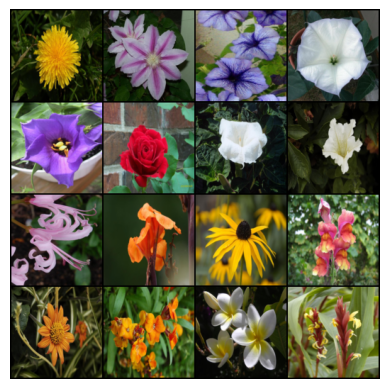

Labels:
common dandelion; clematis; petunia; thorn apple;
bolero deep blue; rose; thorn apple; petunia;
cape flower; canna lily; black-eyed susan; snapdragon;
orange dahlia; wallflower; frangipani; cautleya spicata;


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# get some random training images
dataiter = iter(DataLoader(train_dataset, batch_size=16, shuffle=True))
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=4))
# print labels
print("Labels:")
for i in range(4):
    print(' '.join(f'{classes[int(labels[j])]};' for j in range(i*4, (i+1)*4)))

## CNN model

In [141]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(img_resize//8 * img_resize//8 * 128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 102)
        # Activation and dropout

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Define how data flows through the network
        x = self.pool(F.relu(self.conv1(x)))  # n x n x 32  -> n/2 x n/2 x 32
        x = self.pool(F.relu(self.conv2(x)))  #             -> n/4 x n/4 x 64
        x = self.pool(F.relu(self.conv3(x)))  #             -> n/8 x n/8 x 128
        x = x.view(-1, img_resize//8 * img_resize//8 * 128)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Training parameters

In [142]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training function that also tracks the history

In [143]:
def train_CNN(model, train_loader, val_loader, criterion, optimizer, epochs):

    history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(train_loader):
            
            inputs, labels = data

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()  # Clear old gradients
            loss.backward()         # Compute gradients
            optimizer.step()        # Update weights 

            # Track accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
            
            # Print progress
            if i % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * float(correct) / total
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        
        # Update history
        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1} complete. Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n')
        
    return history


In [144]:
history = train_CNN(model, train_loader, val_loader, criterion, optimizer, epochs=20)

# Save model and training history
torch.save(model.state_dict(), './models/flowers_unsegmented_model.pt')
np.save('./models/flowers_unsegmented_history.npy', history)

# # Load
# model.load_state_dict(torch.load('./models/flowers_unsegmented_model.pt', weights_only=True))
# history=np.load('./models/flowers_unsegmented_history.npy',allow_pickle=True).item()


Epoch 1/20, Batch 0/49, Loss: 4.6230
Epoch 1/20, Batch 10/49, Loss: 4.5128
Epoch 1/20, Batch 20/49, Loss: 4.3774
Epoch 1/20, Batch 30/49, Loss: 4.2868
Epoch 1/20, Batch 40/49, Loss: 3.9598
Epoch 1 complete. Train Loss: 4.3133, Train Acc: 5.55%, Val Loss: 4.2877, Val Acc: 3.92%

Epoch 2/20, Batch 0/49, Loss: 3.8433
Epoch 2/20, Batch 10/49, Loss: 3.7619
Epoch 2/20, Batch 20/49, Loss: 3.4427
Epoch 2/20, Batch 30/49, Loss: 3.6804
Epoch 2/20, Batch 40/49, Loss: 3.6158
Epoch 2 complete. Train Loss: 3.7056, Train Acc: 12.73%, Val Loss: 3.7878, Val Acc: 8.73%

Epoch 3/20, Batch 0/49, Loss: 3.5498
Epoch 3/20, Batch 10/49, Loss: 3.2796
Epoch 3/20, Batch 20/49, Loss: 3.3667
Epoch 3/20, Batch 30/49, Loss: 3.2373
Epoch 3/20, Batch 40/49, Loss: 3.1440
Epoch 3 complete. Train Loss: 3.2594, Train Acc: 19.08%, Val Loss: 3.4100, Val Acc: 15.59%

Epoch 4/20, Batch 0/49, Loss: 3.0034
Epoch 4/20, Batch 10/49, Loss: 3.2723
Epoch 4/20, Batch 20/49, Loss: 2.9573
Epoch 4/20, Batch 30/49, Loss: 2.7833
Epoch 4/2

Let's plot the evolution of the loss and the accuracy throughout training. We can see that the validation loss first goes down, then back up somewhere between the 5th and the 10th epochs, and the validation accuracy pretty much stagnates from there onwards. This indicates that we have a problem with overfitting, especially when considering the high training accuracy.

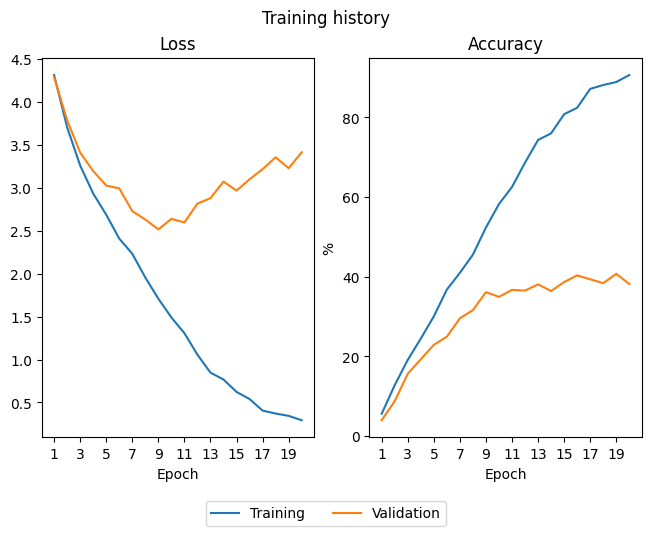

In [192]:
fig, axs = plt.subplots(1, 2, layout='constrained')

ax = axs[0]
ax.plot(history['loss'], label='Training')
ax.plot(history['val_loss'], label='Validation')
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0,20,2),labels=np.arange(1,21,2))
ax.set_title("Loss")

ax = axs[1]
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0,20,2),labels=np.arange(1,21,2))
ax.set_ylabel("%")
ax.set_title("Accuracy")

fig.suptitle("Training history")
fig.legend(ncols=4, loc='lower center',bbox_to_anchor=(0.5, -0.1))
plt.show()

We can check on a few examples that the classification is far from accurate.

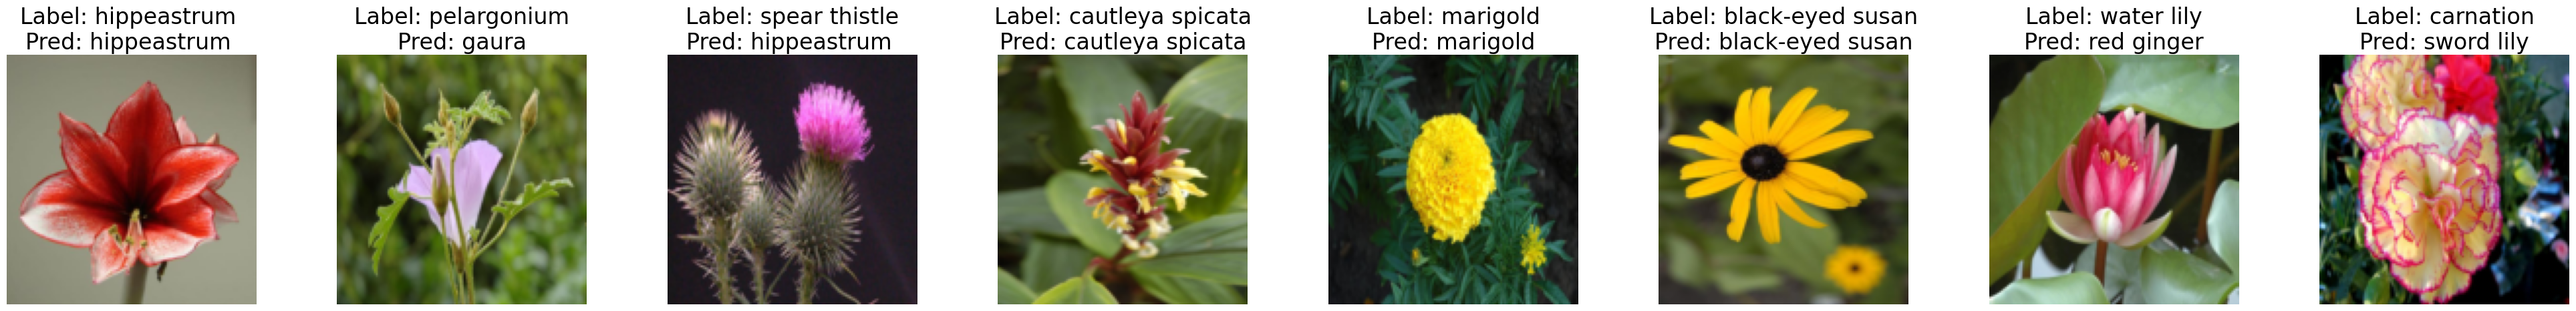

In [160]:
n_show = 8
dataiter = iter(DataLoader(test_dataset, batch_size=n_show, shuffle=True))
images, labels = next(dataiter)

# print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: \t', ' '.join(f'{j}={classes[int(labels[j])]} |' for j in range(n_show)))

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# print('Predicted: \t', ' '.join(f'{j}={classes[int(predicted[j])]} |' for j in range(n_show)))


plt.figure(figsize=(40,5))

for i in range(n_show):
    image = images[i]
    label = labels[i]
    pred_label = predicted[i]
    ax = plt.subplot(1, n_show, i + 1)
    plt.tight_layout()
    ax.set_title('Label: {}\nPred: {}'.format(class_names[label], class_names[pred_label]), fontsize=24)
    ax.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))

plt.show()


### Model evaluation: calculating the overall test accuracy and the accuracy for each class

In [147]:
# Accuracy on the test dataset
correct = 0
total = 0

# count predictions for each class
correct_pred = {classname: 0 for classname in classes.values()}
total_pred = {classname: 0 for classname in classes.values()}

y_pred = []
y_true = []

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        # Totals for calculating accuracy
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[int(label)]] += 1
            total_pred[classes[int(label)]] += 1
            y_pred.append(prediction)
            y_true.append(label)

print(f'Overall accuracy of the network on 1,020 test images: {100 * correct // total} %\n')

# print accuracy for each class
print('Accuracy for each class (10 test samples per class):\n')

# pretty print
max_len = max([len(c) for c in classes.values()])
spaces = {c: ' '*(max_len - len(c)) for c in classes.values()}

accuracy_vs_sample_size = dict()

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{classname}{spaces[classname]}: {accuracy:.1f} % (total samples {total_samples[classname]})')
    
    accuracy_vs_sample_size[total_samples[classname] - 20] = accuracy # number of samples in training set = total samples - 10 in validation set - 10 in test set

Overall accuracy of the network on 1,020 test images: 39 %

Accuracy for each class (10 test samples per class):

pink primrose            : 0.0 % (total samples 40)
hard-leaved pocket orchid: 100.0 % (total samples 60)
canterbury bells         : 10.0 % (total samples 40)
sweet pea                : 10.0 % (total samples 56)
english marigold         : 40.0 % (total samples 65)
tiger lily               : 10.0 % (total samples 45)
moon orchid              : 30.0 % (total samples 40)
bird of paradise         : 80.0 % (total samples 85)
monkshood                : 10.0 % (total samples 46)
globe thistle            : 50.0 % (total samples 45)
snapdragon               : 0.0 % (total samples 87)
colt's foot              : 70.0 % (total samples 87)
king protea              : 30.0 % (total samples 49)
spear thistle            : 80.0 % (total samples 48)
yellow iris              : 40.0 % (total samples 49)
globe-flower             : 0.0 % (total samples 41)
purple coneflower        : 100.0 % (tota

We can see that accuracy varies a lot from one class to another. Running a linear regression allows us to check whether accuracy relates to the number of training samples in each class. With a low number of epochs (up to 10) we get a $p$-value under 0.05, but this is no longer true when increasing the number of epochs: on a run of 20 epochs, we get $p=0.0942$.

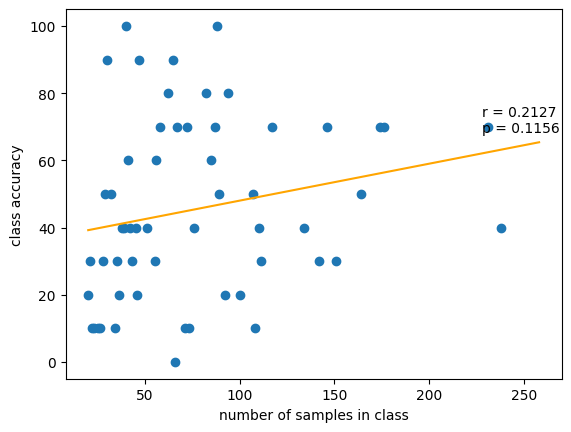

In [148]:
from scipy import stats

x = list(accuracy_vs_sample_size.keys())
y = list(accuracy_vs_sample_size.values())

slope, intercept, r, p, std_err = stats.linregress(x, y)

xs = np.linspace(20, max(total_samples.values()), num=len(x))
ys = slope * xs + intercept

# Plot regression line
plt.figure()
plt.scatter(x, y)
plt.plot(xs, ys, color="orange")
plt.annotate(f"r = {r:.4f}\np = {p:.4f}", xy=(xs[-1]-30,ys[-1]+3))
plt.xlabel("number of samples in class")
plt.ylabel("class accuracy")
plt.show()

Finally, let's print the confusion matrix. It shows again that accuracy is very variable across categories, as shown by the varying intensity of blue on the diagonal.

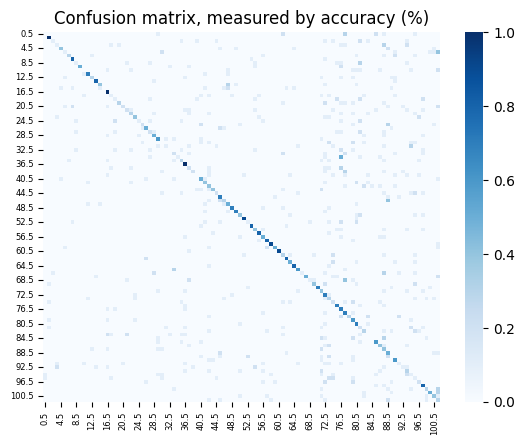

In [149]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
ax = sns.heatmap(df_cm, annot=False, cmap='Blues')
ax.set_xticklabels(ax.get_xticks(), size = 6)
ax.set_yticklabels(ax.get_yticks(), size = 6)
ax.set_title("Confusion matrix, measured by accuracy (%)")
plt.show()


## Classification with the segmented images

Let's see what happens when we take segmented images, i.e. the flowers without their background. Can we achieve more accuracy?

### Dataset creation

First we need to create a new dataset from the segmented images. The files are downloaded from [this page](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/).

In [150]:
from skimage import io
import tarfile

In [151]:
tar = tarfile.open("./data/flowers-102/102segmentations.tgz")

if not os.path.exists('./data/flowers-102/segmim'):
    tar.extractall(path="./data/flowers-102/")

In [152]:
class SegDataset(torch.utils.data.Dataset):
    """Segmented Flowers 102 dataset."""

    def __init__(self, mat_file, root_dir, imtransform=None):
        """
        Arguments:
            mat_file (string): Path to the mat file with image labels.
            root_dir (string): Directory with all the images.
            imtransform (callable, optional): Optional transform to be applied.
        """
        self.imlabels = scipy.io.loadmat(mat_file)["labels"]
        self.root_dir = root_dir
        self.imtransform = imtransform
        self.image_files = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.imlabels.reshape(-1))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_files[idx]) # Retrieve the image file name
        image = io.imread(img_name)
        label = self.imlabels[0, idx] - 1 # imagelabels.mat is 1-indexed so we need to substract 1 from each label

        
        if self.imtransform:
            image = self.imtransform(image)

        return image, label

In [153]:
# New transform

# transform_seg = v2.Compose([
#     v2.ToImage(),
#     v2.Resize((128, 128)),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.RandomVerticalFlip(p=0.2),
#     v2.RandomRotation(30, fill=(0,0,254)),
#     v2.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=(0,0,254)),
#     v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
#     v2.ToDtype(torch.float32, scale=True)
# ])

# Load the dataset of segmented images

seg_dataset = SegDataset("./data/flowers-102/imagelabels.mat", "./data/flowers-102/segmim", imtransform=transform)

In [154]:
# Split dataset into training, validation, and test datasets

# setid.mat is 1-indexed so we need to substract 1 from each ID
train_ids = (scipy.io.loadmat("./data/flowers-102/setid.mat")["tstid"] - 1).reshape(-1).tolist()
val_ids = (scipy.io.loadmat("./data/flowers-102/setid.mat")["valid"] - 1).reshape(-1).tolist()
test_ids = (scipy.io.loadmat("./data/flowers-102/setid.mat")["trnid"] - 1).reshape(-1).tolist()

train_seg_dataset = torch.utils.data.Subset(seg_dataset, train_ids)
val_seg_dataset = torch.utils.data.Subset(seg_dataset, val_ids)
test_seg_dataset = torch.utils.data.Subset(seg_dataset, test_ids)

batch_size = 128

train_seg_loader = DataLoader(train_seg_dataset, batch_size=batch_size, shuffle=True)
val_seg_loader = DataLoader(val_seg_dataset, batch_size=batch_size, shuffle=True)
test_seg_loader = DataLoader(test_seg_dataset, batch_size=batch_size, shuffle=False)

print(f"training set size   = {train_seg_dataset.__len__()}")
print(f"validation set size = {val_seg_dataset.__len__()}")
print(f"test set size       = {test_seg_dataset.__len__()}")

training set size   = 6149
validation set size = 1020
test set size       = 1020


We've already started training the model on the unsegmented images, so let's use it as a pre-trained model and continue training it on the segmented dataset.

In [155]:
model_seg = SimpleCNN()
optimizer = optim.Adam(model_seg.parameters(), lr=0.0001)
history_seg = train_CNN(model_seg, train_seg_loader, val_seg_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Batch 0/49, Loss: 4.6313
Epoch 1/10, Batch 10/49, Loss: 4.5814
Epoch 1/10, Batch 20/49, Loss: 4.6188
Epoch 1/10, Batch 30/49, Loss: 4.5206
Epoch 1/10, Batch 40/49, Loss: 4.5669
Epoch 1 complete. Train Loss: 4.5608, Train Acc: 2.96%, Val Loss: 4.6589, Val Acc: 1.57%

Epoch 2/10, Batch 0/49, Loss: 4.5266
Epoch 2/10, Batch 10/49, Loss: 4.4797
Epoch 2/10, Batch 20/49, Loss: 4.3074
Epoch 2/10, Batch 30/49, Loss: 4.3657
Epoch 2/10, Batch 40/49, Loss: 4.4578
Epoch 2 complete. Train Loss: 4.3648, Train Acc: 6.00%, Val Loss: 4.6110, Val Acc: 2.65%

Epoch 3/10, Batch 0/49, Loss: 4.1897
Epoch 3/10, Batch 10/49, Loss: 4.2644
Epoch 3/10, Batch 20/49, Loss: 4.2831
Epoch 3/10, Batch 30/49, Loss: 4.0915
Epoch 3/10, Batch 40/49, Loss: 4.1518
Epoch 3 complete. Train Loss: 4.2257, Train Acc: 7.33%, Val Loss: 4.4897, Val Acc: 2.94%

Epoch 4/10, Batch 0/49, Loss: 4.0423
Epoch 4/10, Batch 10/49, Loss: 4.0958
Epoch 4/10, Batch 20/49, Loss: 4.0968
Epoch 4/10, Batch 30/49, Loss: 4.2514
Epoch 4/10, 

Wow, that's not very good at all! Let's compare with the results obtained on the unsegmented images.

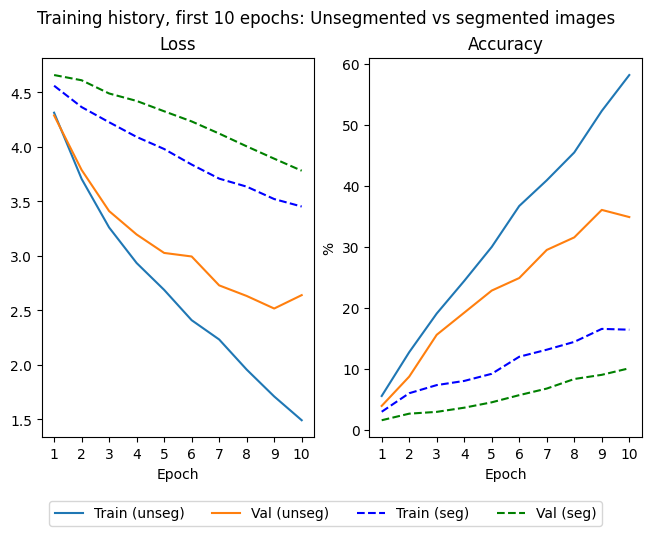

In [187]:
fig, axs = plt.subplots(1, 2, layout='constrained')

ax = axs[0]
ax.plot(history['loss'][:10], label='Train (unseg)')
ax.plot(history['val_loss'][:10], label='Val (unseg)')
ax.plot(history_seg['loss'], 'b--', label='Train (seg)')
ax.plot(history_seg['val_loss'], 'g--', label='Val (seg)')
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0,10,1),labels=np.arange(1,11,1))
ax.set_title("Loss")

ax = axs[1]
ax.plot(history['accuracy'][:10])
ax.plot(history['val_accuracy'][:10])
ax.plot(history_seg['accuracy'], 'b--')
ax.plot(history_seg['val_accuracy'], 'g--')
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0,10,1),labels=np.arange(1,11,1))
ax.set_ylabel("%")
ax.set_title("Accuracy")

fig.suptitle("Training history, first 10 epochs: Unsegmented vs segmented images")
fig.legend(ncols=4, loc='lower center',bbox_to_anchor=(0.5, -0.1))
plt.show()

Taking a look at the segmented images, we can indeed notice that the segmentation isn't perfect - e.g. some images still have a fair chunk of background included, or some of their features have been erased - and that most contextual data (e.g. stems, leaves) is removed in the process. It looks like it is actually making it harder for a CNN to learn to classify these images accurately.

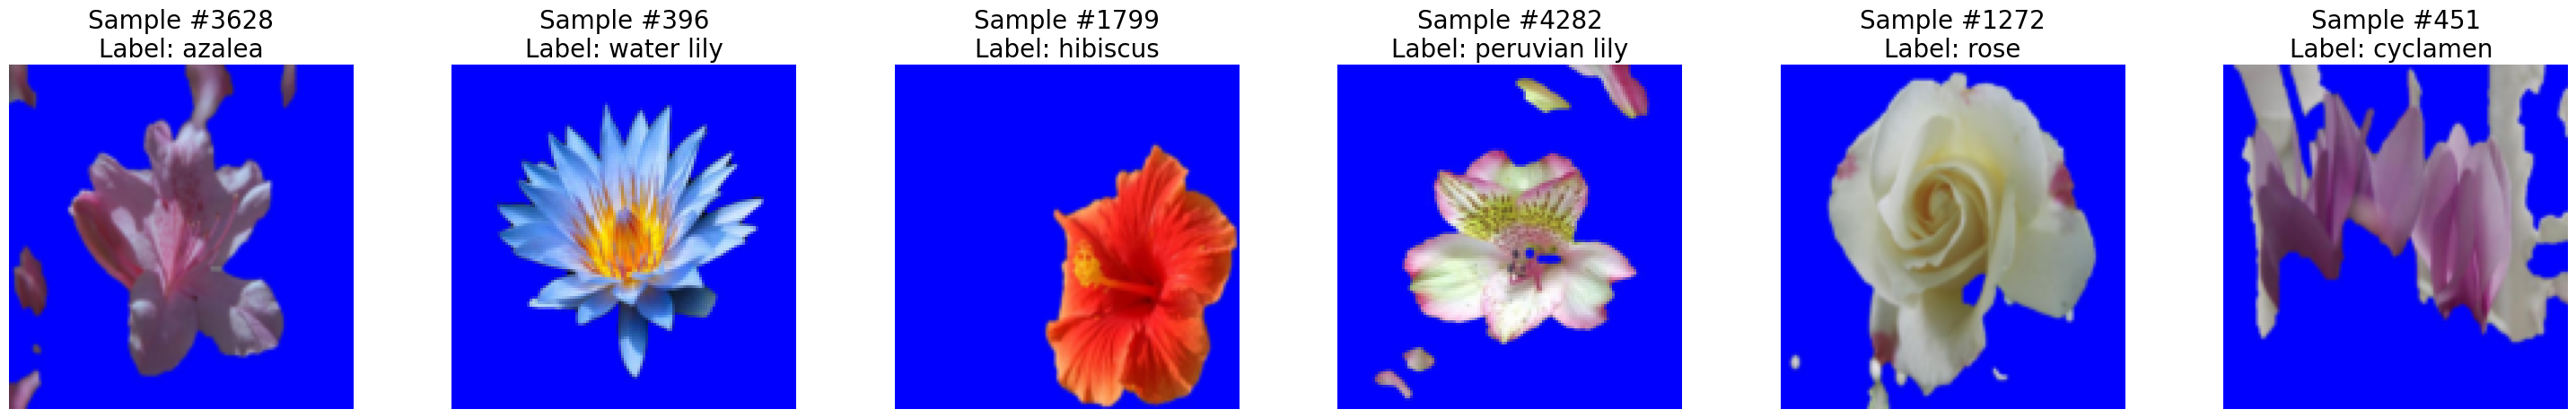

In [157]:
plt.figure(figsize=(30,5))

figs = random.sample(range(len(seg_dataset)), 6)

for i in range(len(figs)):
    image, label = seg_dataset[figs[i]]
    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}\nLabel: {}'.format(figs[i], class_names[label]), fontsize=20)
    ax.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))

plt.show()


Here's an example of not-ideal segmentation:

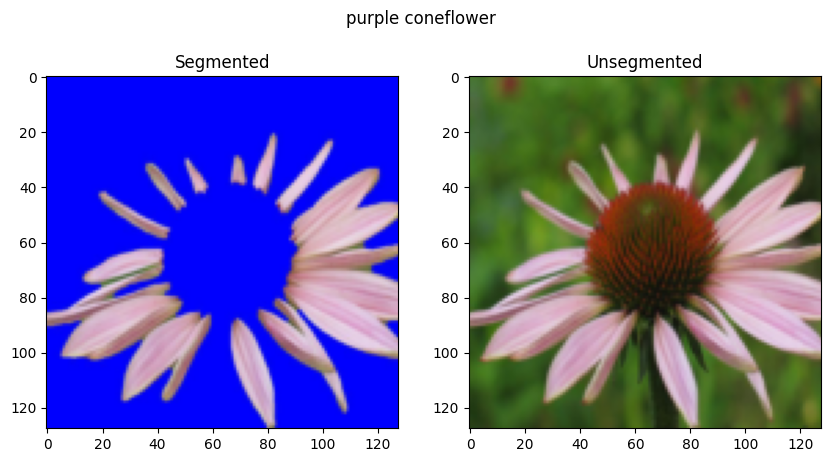

In [158]:
seg_img, seg_label = train_seg_dataset[593]
unseg_img, unseg_label = train_dataset[593]

# Load corresponding unsegmented image and visualize both
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(seg_img.permute(1, 2, 0))
plt.title("Segmented")
plt.subplot(1, 2, 2)
plt.imshow(unseg_img.permute(1, 2, 0))
plt.title("Unsegmented")
plt.suptitle(f"{class_names[seg_label]}")

# Load the same image from unsegmented dataset for comparison
plt.show()